# Construct a binary tree from sklearn decision tree classifier

Sklearn decision trees store their trees as preorder depth first searches. To illustrate how to construct a hierarchical object that can be saved as JSON and loaded to D3, we can look at a simple dataset as the iris.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import json
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

The results are stored in 

In [2]:
clf.tree_.feature

array([ 3, -2,  3,  2,  3, -2, -2,  3, -2,  0, -2, -2,  2,  0, -2, -2, -2])

or here 

In [3]:
clf.tree_.__getstate__()['nodes']

array([( 1,  2,  3,  0.80000001,  0.66666667, 150,  150.),
       (-1, -1, -2, -2.        ,  0.        ,  50,   50.),
       ( 3, 12,  3,  1.75      ,  0.5       , 100,  100.),
       ( 4,  7,  2,  4.94999981,  0.16803841,  54,   54.),
       ( 5,  6,  3,  1.6500001 ,  0.04079861,  48,   48.),
       (-1, -1, -2, -2.        ,  0.        ,  47,   47.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       ( 8,  9,  3,  1.54999995,  0.44444444,   6,    6.),
       (-1, -1, -2, -2.        ,  0.        ,   3,    3.),
       (10, 11,  0,  6.94999981,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (13, 16,  2,  4.85000038,  0.04253308,  46,   46.),
       (14, 15,  0,  5.94999981,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,  43,   43.

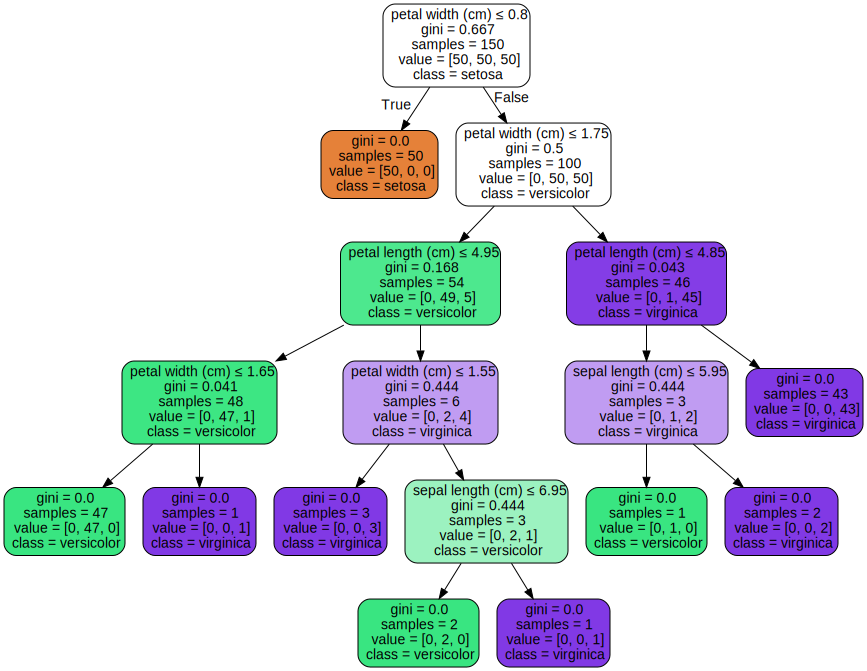

In [4]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## tree construction

We can reconstruct the decision tree by using stacks. Alternatively, we could us recursios.

In [8]:
from collections import deque

# it is currently superfluous to have a node class but might be useful in the future
class Node:
    
    COUNTER = 0
    
    def __init__(self, name):
        self.name = name
        self.children = []
        Node.COUNTER += 1
    
    def add_child(self, child):
        self.children.append(child)

# data for reconstructing the tree
features = clf.tree_.feature
n_samples = clf.tree_.n_node_samples
feature_names = iris.feature_names
values = clf.tree_.value # is it weighted?
thresholds = np.round(clf.tree_.threshold,2)
classes = clf.tree_.predict

# set containers
leaves = deque()
nodes = []

# helper functions
def value_getter(arr):
    return [int(v) for v in arr[0]]


# count the leaf nodes in the tree in order to return a little bit nicer formatted output
n_leaf = sum([feature == -2 for feature in features])

# build the tree in a bottom-up approach
for n, feature in enumerate(reversed(features)):
    this_value = value_getter(values[-(n+1)])
    this_label = feature_names[feature] + '<' + str(thresholds[-(n+1)])
    # if it is a leaf node, append it to leaves and give it a name
    if feature == -2:
        leaf = {'label': 'leaf' + str(n_leaf), 'samples': sum(this_value), 'value': this_value}
        leaves.append(leaf)
        n_leaf -= 1
    # if it is a node, append it to the tree
    else:
  #      node = Node(feature_names[feature])
  #      print(node.COUNTER)
  #      nodes.append(node)
        # add left and right children to the stack
        child1=leaves.pop()
        child2=leaves.pop()
        # temporary stack to store the children
        temp_leaves = []
        # and the nodes 
        temp_node_leaves = {'label': this_label , 'samples': sum(this_value), 
                            'value': this_value}
        temp_leaves.append(child1)
        temp_leaves.append(child2)
        temp_node_leaves['children'] = temp_leaves
        leaves.append(temp_node_leaves)
reconstructed_tree = temp_node_leaves
reconstructed_tree

{'children': [{'label': 'leaf1', 'samples': 50, 'value': [50, 0, 0]},
  {'children': [{'children': [{'children': [{'label': 'leaf2',
         'samples': 47,
         'value': [0, 47, 0]},
        {'label': 'leaf3', 'samples': 1, 'value': [0, 0, 1]}],
       'label': 'petal width (cm)<1.65',
       'samples': 48,
       'value': [0, 47, 1]},
      {'children': [{'label': 'leaf4', 'samples': 3, 'value': [0, 0, 3]},
        {'children': [{'label': 'leaf5', 'samples': 2, 'value': [0, 2, 0]},
          {'label': 'leaf6', 'samples': 1, 'value': [0, 0, 1]}],
         'label': 'sepal length (cm)<6.95',
         'samples': 3,
         'value': [0, 2, 1]}],
       'label': 'petal width (cm)<1.55',
       'samples': 6,
       'value': [0, 2, 4]}],
     'label': 'petal length (cm)<4.95',
     'samples': 54,
     'value': [0, 49, 5]},
    {'children': [{'children': [{'label': 'leaf7',
         'samples': 1,
         'value': [0, 1, 0]},
        {'label': 'leaf8', 'samples': 2, 'value': [0, 0, 2]}],

With a little bit nicer formatting, we can see that this corresponds to the structure that d3 tree layout expects.

In [9]:
print(json.dumps(reconstructed_tree, indent=4)) 

{
    "label": "petal width (cm)<0.8",
    "samples": 150,
    "value": [
        50,
        50,
        50
    ],
    "children": [
        {
            "label": "leaf1",
            "samples": 50,
            "value": [
                50,
                0,
                0
            ]
        },
        {
            "label": "petal width (cm)<1.75",
            "samples": 100,
            "value": [
                0,
                50,
                50
            ],
            "children": [
                {
                    "label": "petal length (cm)<4.95",
                    "samples": 54,
                    "value": [
                        0,
                        49,
                        5
                    ],
                    "children": [
                        {
                            "label": "petal width (cm)<1.65",
                            "samples": 48,
                            "value": [
                                0,
      

In [10]:
with open('../data/tree.json', 'w') as fp:
    json.dump(reconstructed_tree, fp, indent = 4)